# Gaussian Mixture Model: S&P500

In this code I will use the "pymc" package to model the S&P500 returns as a Gaussian Mixture Model as proposed in Tsay (2010). The objective of the modeling is to find two clusters within the distribution of returns. The market has two main behaviors: relaxed and stressed. The first cluster (stressed market) is expected to have a negative mean returns and a higher variance due to volatility caused by uncertainty (due to wars, covid crisis...). The relaxed market tends to have positive and discrete returns and this phase is estimated to be 70% of the time as stated in the documentation.

It is very useful to be able to model the returns of an asset using a Gaussian Mixture Model because it shares many of the characteristics of Gaussian models, so it would be very useful in applications such as portfolio optimization.  

In [1]:
#Import packages

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# Import Data 
prices_ask = pd.read_csv(r"C:~USA500IDXUSD_1 Min_Bid_2011.09.19_2023.02.26.csv", sep = ",")
prices_ask["Time (EET)"] = pd.to_datetime(prices_ask["Time (EET)"], format='%Y.%m.%d %H:%M:%S')
prices_ask.set_index("Time (EET)", inplace=True)
prices_ask = prices_ask.between_time('16:30', '23:00')
prices_ask = prices_ask.loc['2018-03-01':]
prices_ask = prices_ask.dropna()

prices = prices_ask.groupby([pd.Grouper(level =0, freq='D')])["Close"].last()
prices = prices.dropna()
display(prices.head())
print("Cantidad de datos: ", len(prices))

Time (EET)
2018-03-01    2675.769
2018-03-02    2689.969
2018-03-05    2721.169
2018-03-06    2727.869
2018-03-07    2726.870
Name: Close, dtype: float64

Cantidad de datos:  1294


In this case, continuous returns will not be used, but in percentage, since in this way, the distribution tends to have heavier tails.

In [4]:
#returns = np.log(prices/prices.shift()).dropna()
returns = prices.pct_change().dropna()
returns = returns[returns != 0]
display(returns.head())
print("Cantidad de días: ", len(returns))

Time (EET)
2018-03-02    0.005307
2018-03-05    0.011599
2018-03-06    0.002462
2018-03-07   -0.000366
2018-03-08    0.004364
Name: Close, dtype: float64

Cantidad de días:  1290


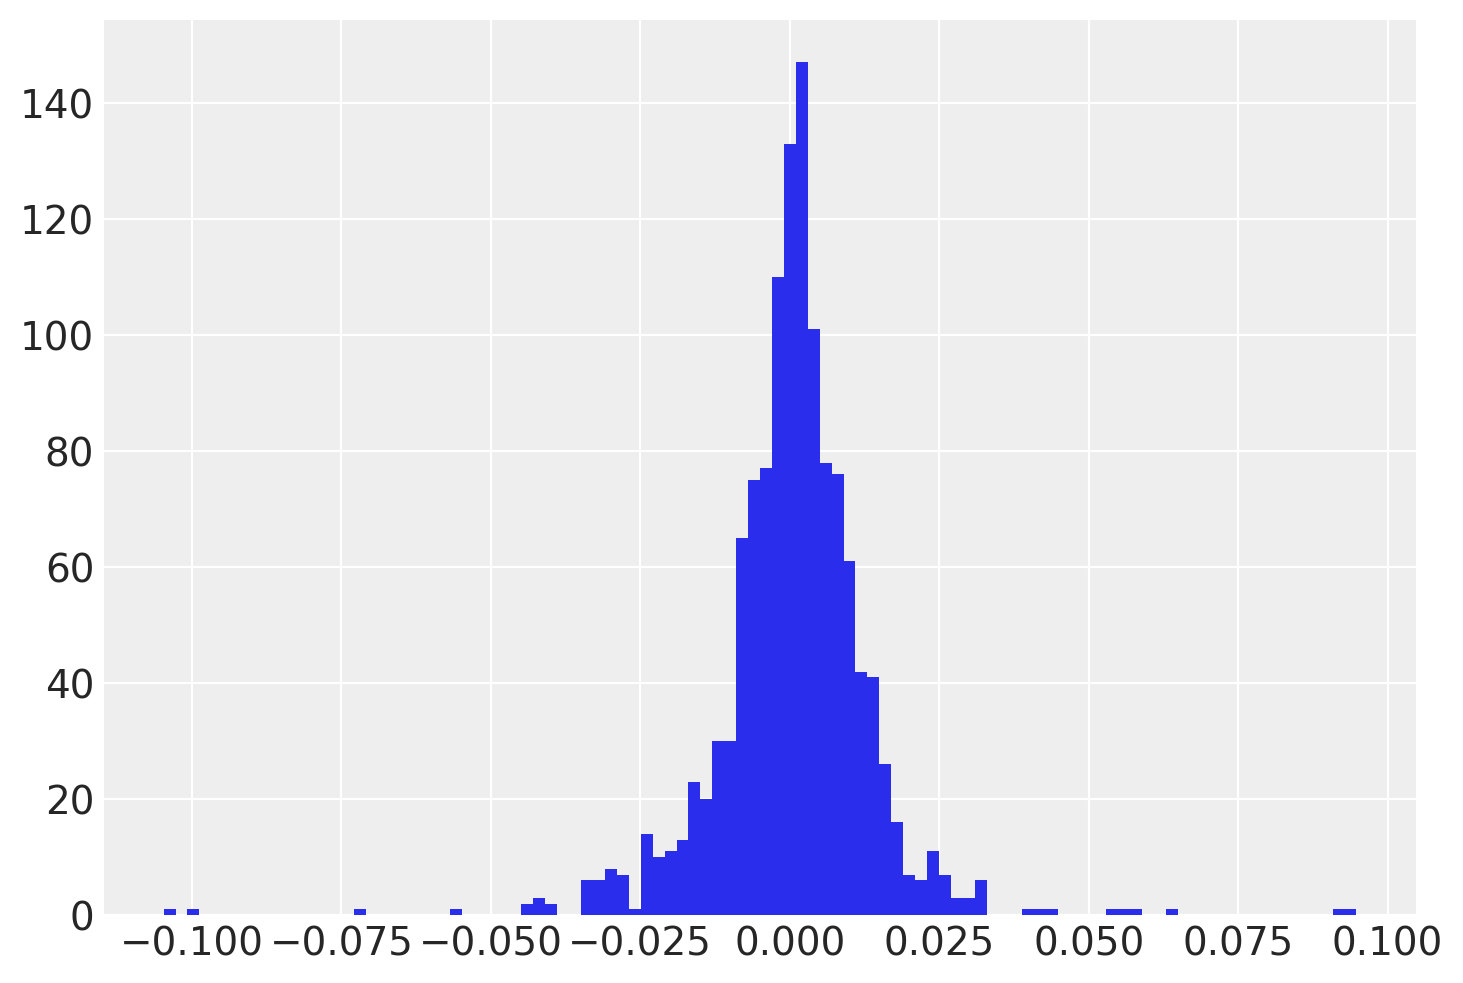

In [62]:
# Plot of the % of daily returns of the S&P500 from 2018 to 2023
k = 2
ndata = len(returns)

plt.hist(returns, 100);

### Model

Our objective in modeling the distribution is to find the mean values of the two clusters as well as their variance. With the values obtained, we will be able to model the returns of the S&P500.

$$
f(y) = \pi_1 \frac{1}{\sigma_1(x)} \phi \left( \frac{y - \mu_1(x)}{\sigma_1(x)} \right) + \pi_2 \frac{1}{\sigma_2(x)} \phi \left( \frac{y - \mu_2(x)}{\sigma_2(x)} \right)
$$

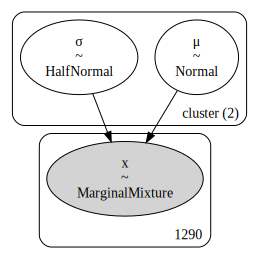

In [41]:
with pm.Model(coords={"cluster": range(k)}) as model:
    
    μ = pm.Normal(
        "μ",
        mu=[-0.10,0.10], 
        sigma=1,
        transform=pm.distributions.transforms.ordered,
        initval=[-0.10,0.10],
        dims="cluster",
    )
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    #weights = pm.Dirichlet('w', a=np.array([3,7]))
    weights = [0.3,0.7]
    pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=returns)

pm.model_to_graphviz(model)

In [42]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


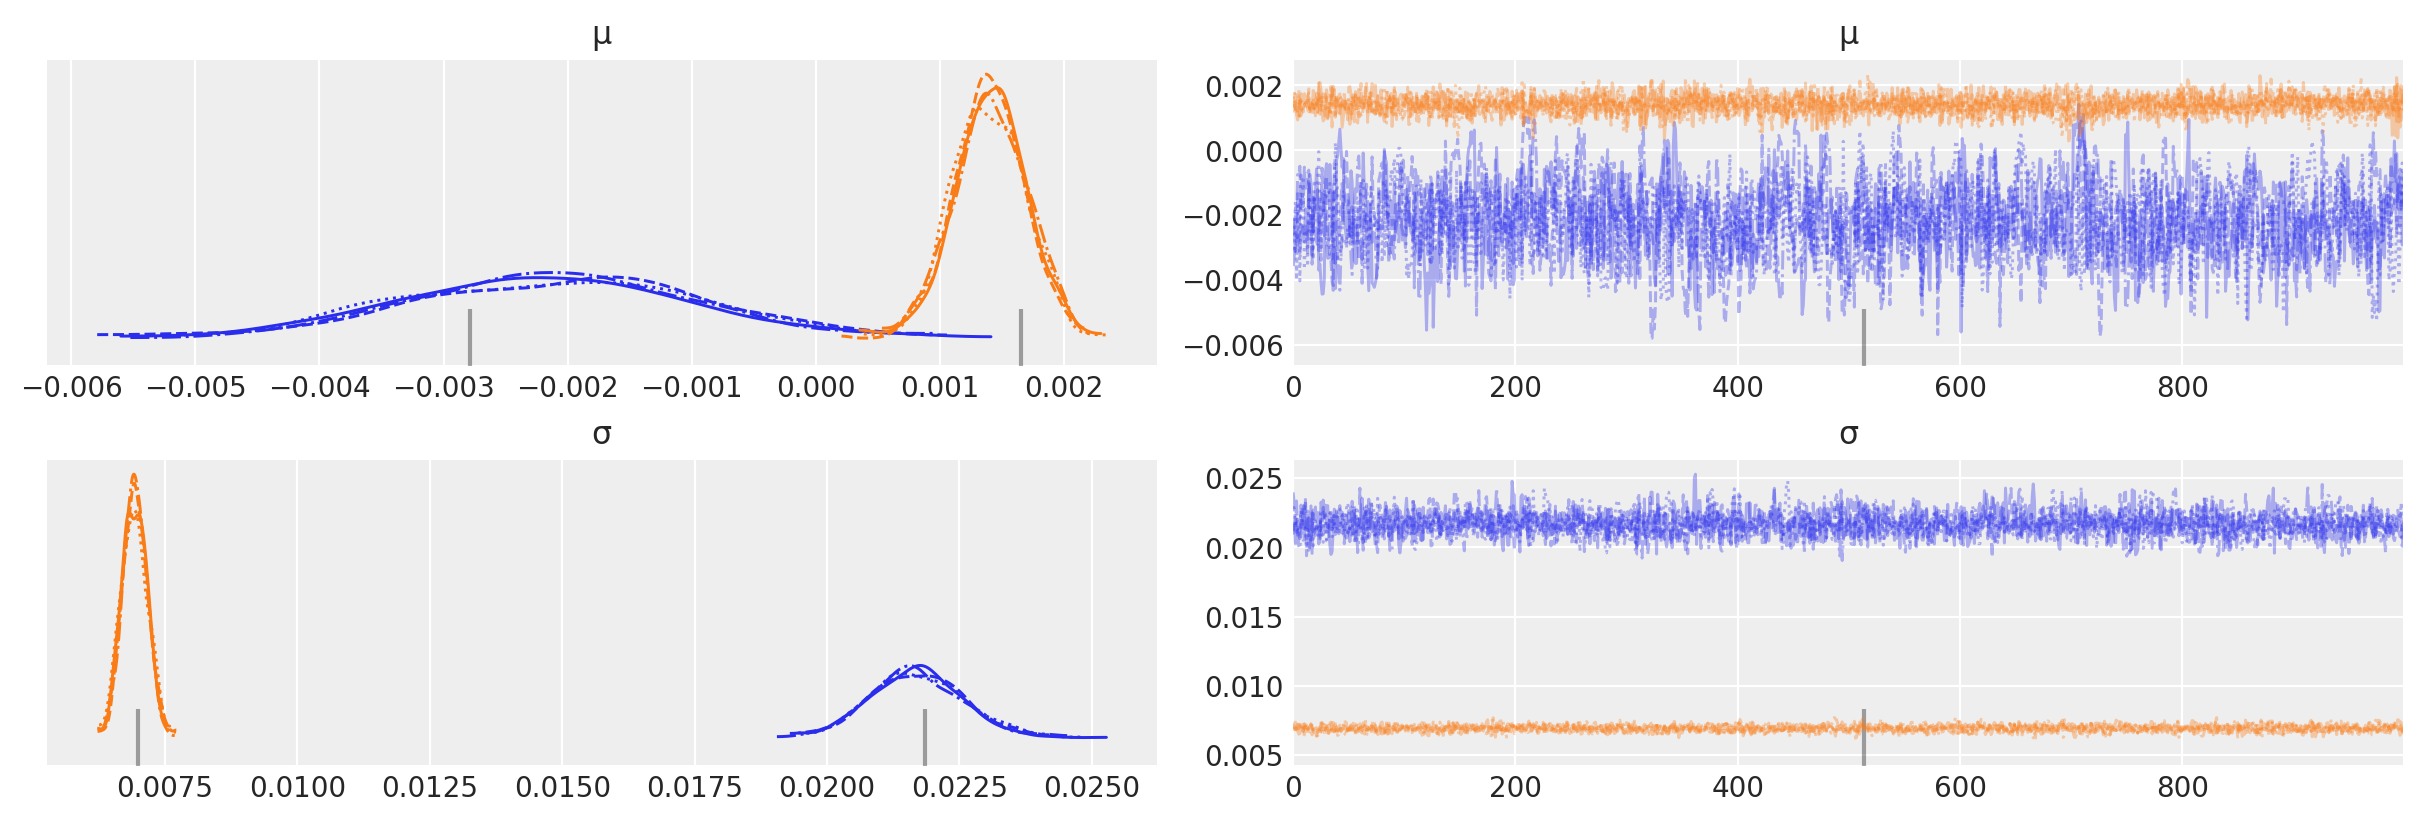

In [43]:
az.plot_trace(idata, var_names=["μ", "σ"]);
#Blue: stressed market
#Orange: relaxed market

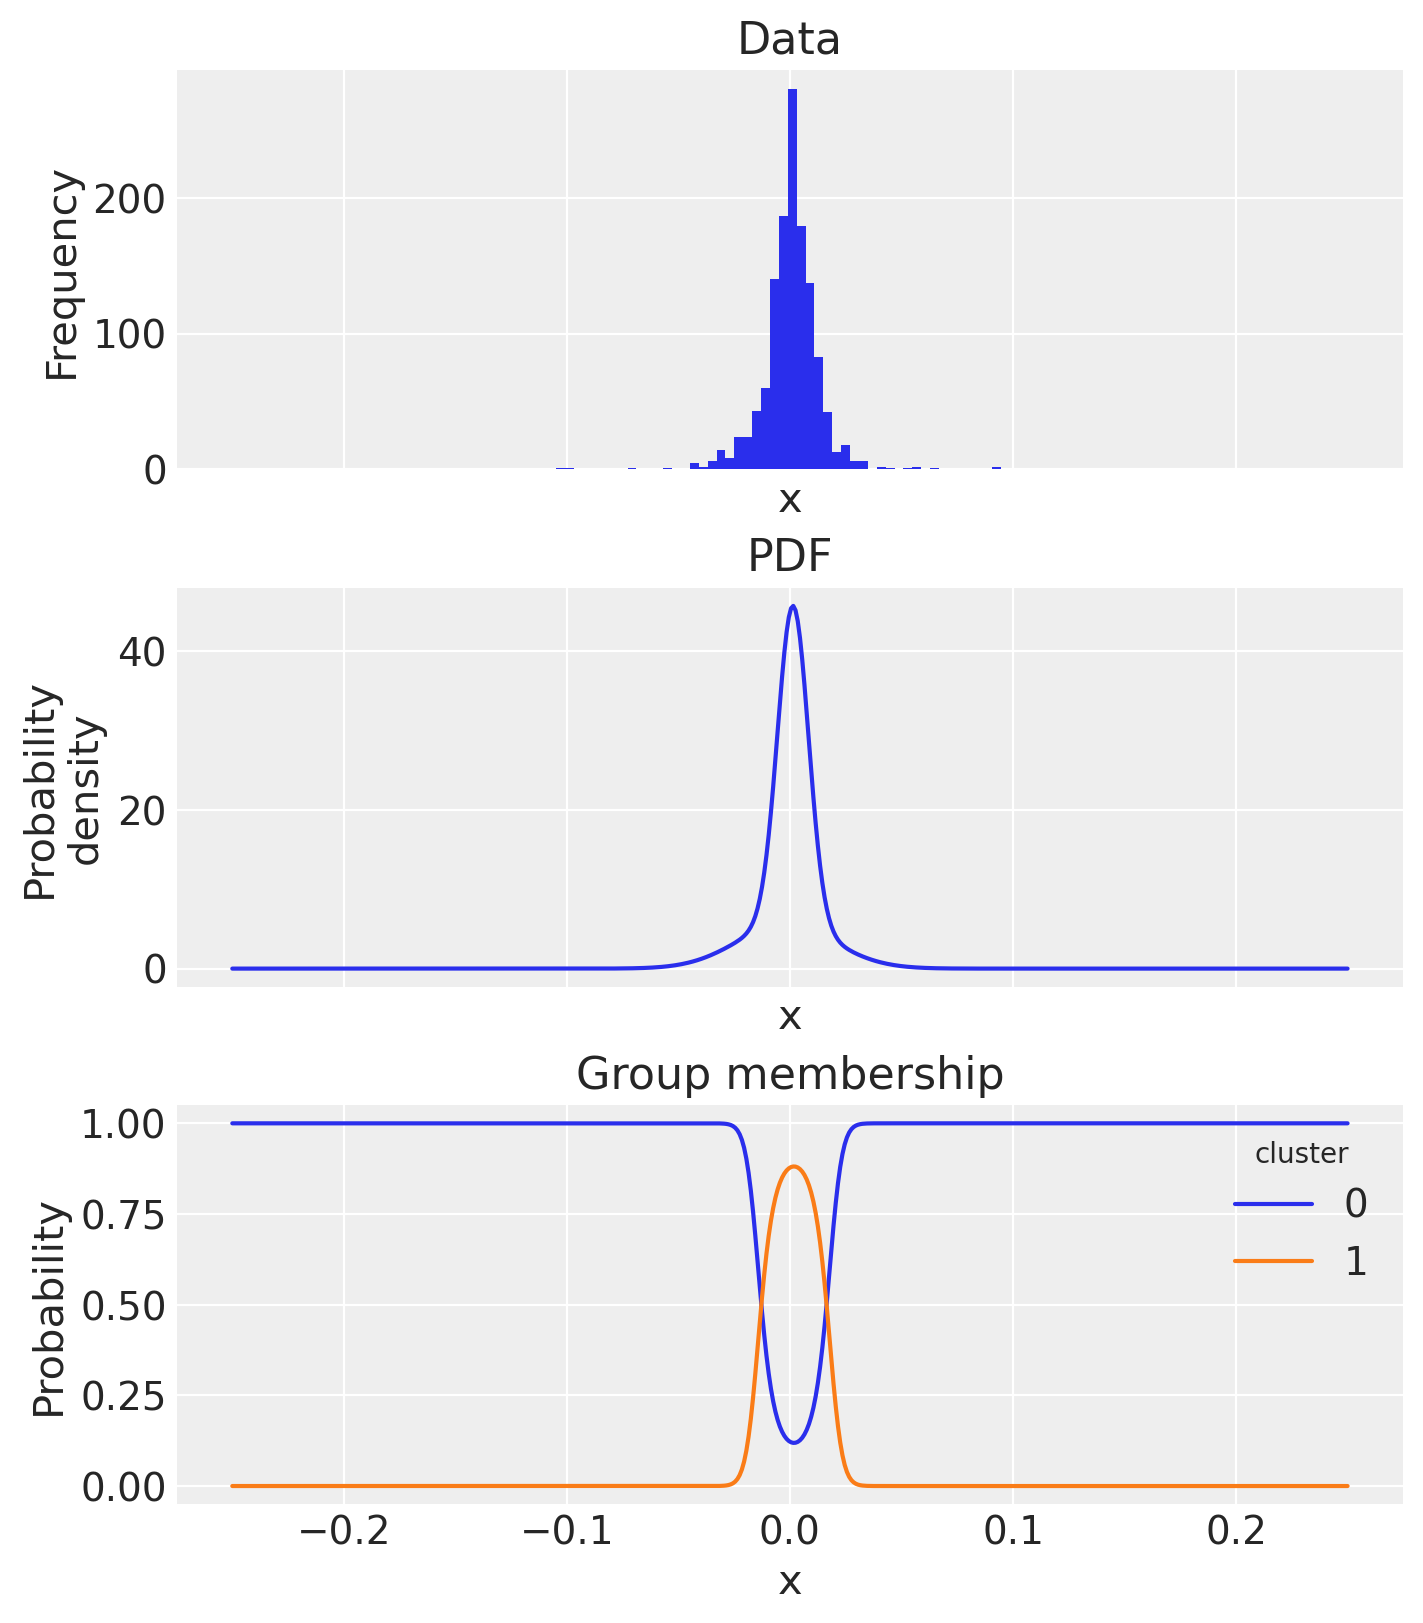

In [44]:
xi = np.linspace(-0.25, 0.25, 500)
post = idata.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * weights
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
# empirical histogram
ax[0].hist(returns, 50)
ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

In [57]:
idata.posterior["μ"][0]

<xarray.DataArray 'μ' (draw: 1000, cluster: 2)>
array([[-0.00214351,  0.0016624 ],
       [-0.0028246 ,  0.00135098],
       [-0.00303619,  0.00172889],
       ...,
       [-0.00107129,  0.00200223],
       [-0.00292095,  0.00125725],
       [-0.00131422,  0.00164039]])
Coordinates:
    chain    int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * cluster  (cluster) int32 0 1

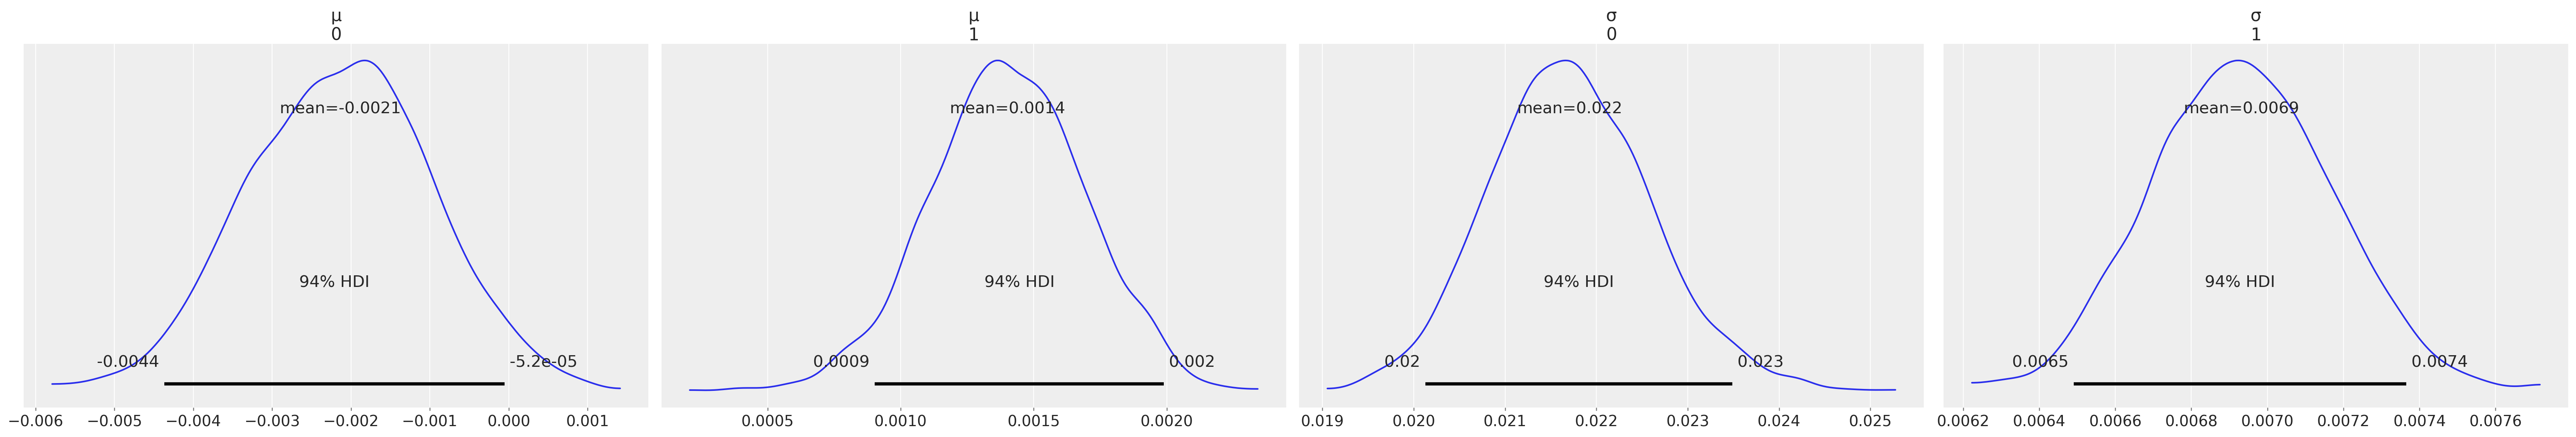

In [58]:
az.plot_posterior(idata, show=True);

All the Rhat values seem to be near 1, so there's no sign of divergence during the simulation. We can also observe that the standard deviation values of both clusters are very different. When the market is stressed, the value of the standard deviation is much higher, thus confirming our hypothesis.

In [61]:
az.summary(idata, var_names=["μ", "σ"], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],-0.0021,0.0012,-0.0044,-0.0001,0.0,0.0,1147.7272,1156.0113,1.0054
μ[1],0.0014,0.0003,0.0009,0.0020,0.0,0.0,3124.3416,2677.4317,1.0010
σ[0],0.0217,0.0009,0.0201,0.0235,0.0,0.0,2507.4719,1927.7177,1.0005
σ[1],0.0069,0.0002,0.0065,0.0074,0.0,0.0,2489.2173,2262.8773,1.0029


The final result would be...

$$
f(y) = 0.3 \frac{1}{0.0217} \phi \left( \frac{y - (-0.0021)}{0.0217} \right) + 0.7 \frac{1}{0.0069} \phi \left( \frac{y - 0.0014}{0.0069} \right)
$$